In [1]:
# This notebook shows how to extract Metamorph .tif timestamps.
# It also uses the TrackerPy package to analyze the distribution 
# of bias of detected particles in bead video.

In [2]:
# Import packages
from __future__ import division, unicode_literals, print_function
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp
import scipy, pims
from scipy import interpolate, signal
from libtiff import TIFF
from pandas import DataFrame, Series  # for convenience

import metamorph_timestamps

mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [3]:
# Path to tif stack 

# ***before running, save .sif as .tif in ImageJ

# fname = './spinners2' 
fname = './spinners2' 
tifname = fname + '.tif'

print (pims.__version__)
raw_frames = pims.TiffStack(tifname, as_grey=False)[0]
print (raw_frames.shape)
bad_frames = np.fromstring(raw_frames.data, dtype=np.int32)
print (bad_frames.shape)
bad_frames = np.reshape(bad_frames, (-1, 512, 512))


def convert_to_8bit(image):
    # from int32
    im = image.astype(np.float64)
    im2 = (im - im.min())
    im2 = im2*255/im2.max()
    im2 = np.uint8(im2)
    return im2

def fix_image(image):
    # the halves of the converted .sif image are flipped.
    im = convert_to_8bit(image)
    fixed = np.hstack([im[:,256:], im[:,:256]])
    return fixed

frames = []
for frame in bad_frames:
    frames += [fix_image(frame)]
frames = np.array(frames)

0.3.3
(200, 512, 512)
(52428800,)


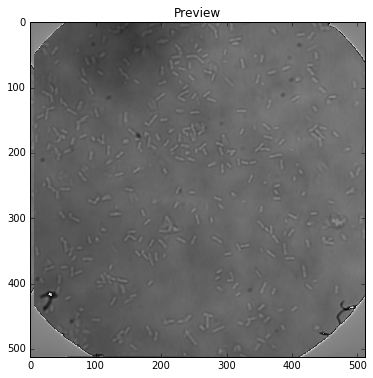

In [4]:
# Preview a frame
preview_image = frames[0]
plt.figure()
plt.title('Preview')
plt.imshow(preview_image)
plt.show()

In [5]:
# TrackPy

In [6]:
# Find features on first frame that satisfy tp.locate function arguments.
f = tp.locate(frames[0], diameter=11, percentile=80, invert=False, minmass=30)

In [7]:
f.head() # shows the first few rows of data

,x,y,mass,size,ecc,signal,raw_mass,ep
0,459.534812,4.536875,1081.293207,2.979472,0.303424,40.151166,10184.0,0.144350
1,232.882883,5.911197,433.298000,2.829792,0.525946,16.171997,7163.0,-0.487600
2,275.357143,7.265499,413.780072,3.017469,0.545992,15.614342,8701.0,0.396810
3,306.676823,7.161045,512.485022,2.882350,0.440176,18.402618,8918.0,0.315953
4,202.472125,5.993031,320.094018,2.751306,0.227471,12.268412,6392.0,-0.230294


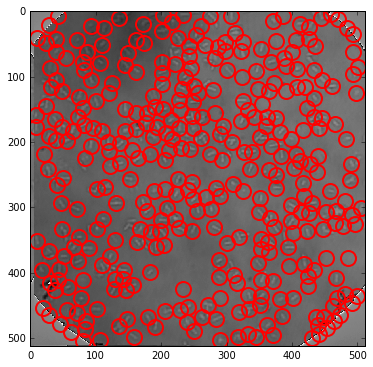

In [8]:
# Preview features of first frame.
plt.figure()
tp.annotate(f, frames[0]); 

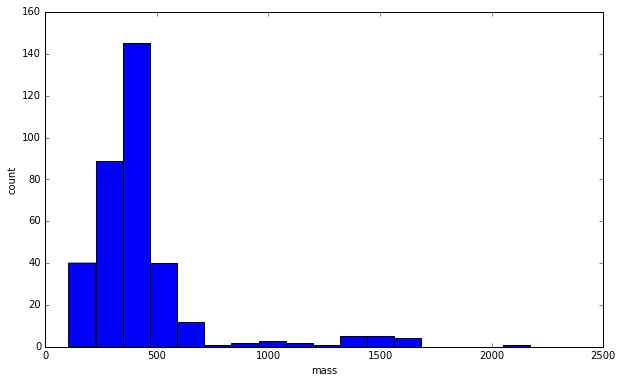

In [9]:
# Examine the mass distributions of found features.
# Mass corresponds to brightnesss.
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=17)

ax.set(xlabel='mass', ylabel='count');

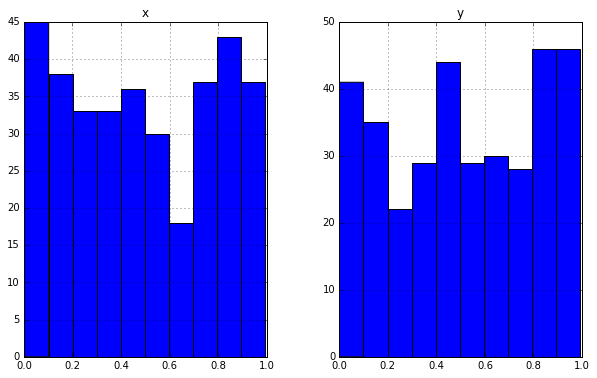

In [10]:
# View subpixel bias (should be approx. uniform distribution)
plt.figure()
tp.subpx_bias(f);

In [11]:
# Find features in all frames
f = tp.batch(frames[:], diameter=11, percentile=80, invert=False, minmass=150)

Frame 199: 363 features


In [12]:
# We have the locations of the particles in each frame. 
# Next we'll track particles from frame to frame, giving each one a number for identification.
# search_range = the farthest a particle can travel between frames (in pixels).
# memory = the number a frames a particle might temporarily disappear.

t = tp.link_df(f, search_range=5, memory=2)
t.head()

Frame 199: 363 trajectories present


,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,459.534812,4.536875,1081.293207,2.979472,0.303424,40.151166,10184.0,0.144350,0,0.0
1,459.545316,4.543797,1073.408321,2.982820,0.302030,40.218843,10188.0,0.142747,1,0.0
2,459.563480,4.567021,1070.796096,2.979953,0.311034,40.622007,10220.0,0.144246,2,0.0
3,459.530820,4.527764,1064.647286,2.979895,0.301636,41.219151,10227.0,0.141314,3,0.0
4,459.549595,4.552126,1073.937979,2.979094,0.309430,40.761816,10235.0,0.149048,4,0.0


In [13]:
# threshold = minimum duration (in frames) of a particle to be counted
# Careful: when the the duration of a detected particle is less than the length of
# the stream, the trajectory (which remains as long as the stream for all particles)
# will have NaN values in at times when the particle was not actively detected.
# This is handles by the get_nan_streaks function.
t1 = tp.filter_stubs(t, threshold=0.50*len(frames)) 

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 2427
After: 279


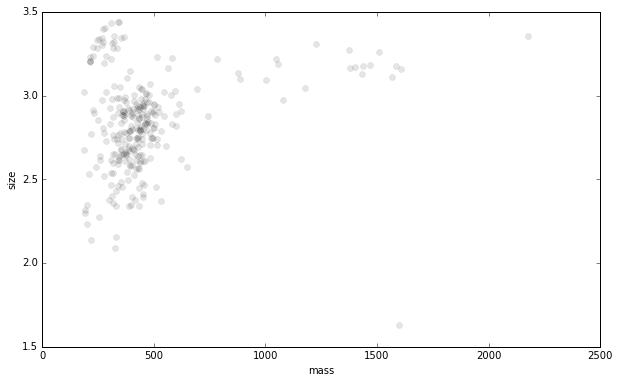

In [14]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # plot size vs. mass

In [15]:
# The particles with especially low mass or especially large size are probably out
# of focus or aggregated, respectively. It is best to experiment by trial and error,
# filtering out regions of mass-size space and looking at the results using
# tp.annotate and tp.circle. In the end, we need to separate the good particles from
# the spurious ones, and it doesn't matter how we get it done.

t2 = t1[((t1['mass'] > 200) & (t1['size'] < 20) &
         (t1['ecc'] > 0.35))]

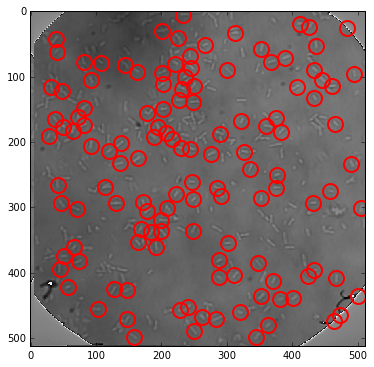

In [16]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

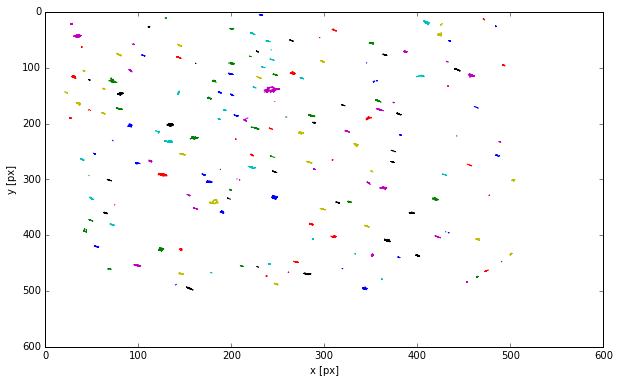

In [17]:
plt.figure()
tp.plot_traj(t2);

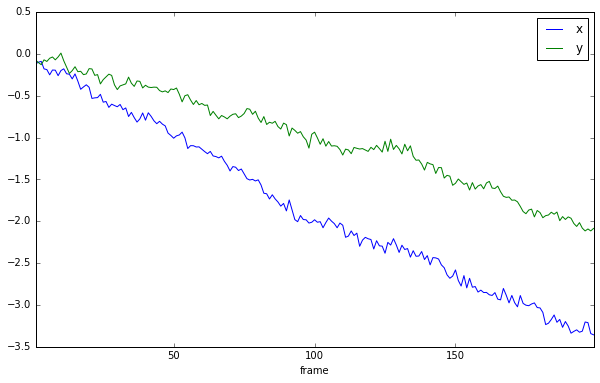

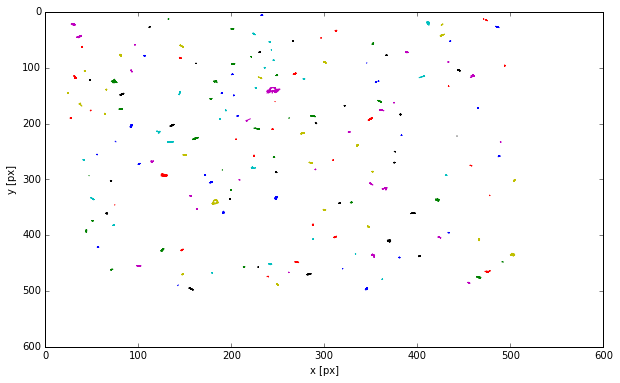

In [18]:
# Compute the overall drifting motion, which we will subtract away,
# adopting the reference frame of the particles' average position.

d = tp.compute_drift(t2)

plt.figure()
d.plot();

tm = tp.subtract_drift(t2.copy(), d)

plt.figure()
ax = tp.plot_traj(tm)

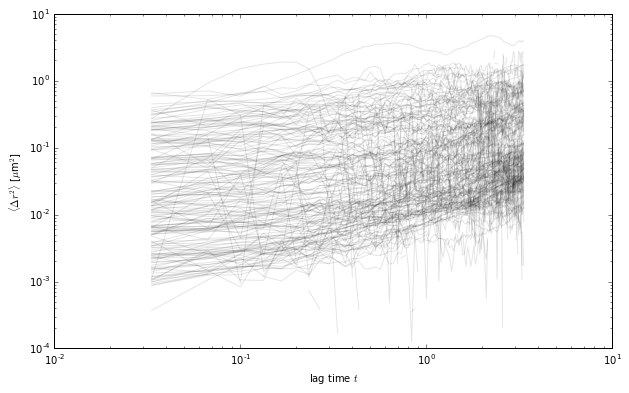

In [19]:
# View mean-square displacement vs lag time for features.
# mpp = microns per pixel = 100/300 (estimate), frames per second = 30
mpp = 100/300. # microns per pixel = 100/300
im = tp.imsd(tm, mpp=mpp, fps=30)  

# Plot
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [20]:
# Load trajectories into a convenient format
pos_columns = ['x', 'y']
particle_paths = tm.set_index(['particle', 'frame'])[pos_columns].unstack()

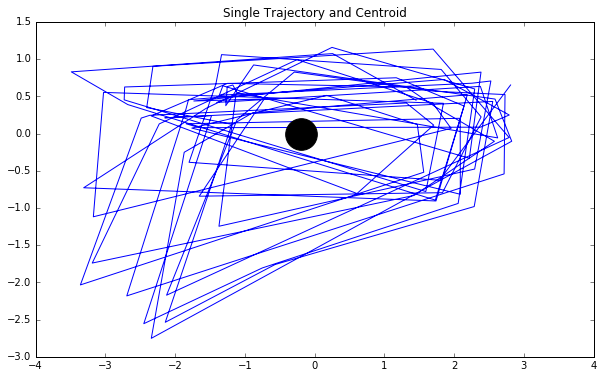

In [42]:
# Analyze rotation of a single particle
i = 46
p = particle_paths.iloc[i]
path = np.array([p['x'],p['y']]).T
centroid = np.nanmean(path,axis=0)

plt.figure()
plt.title('Single Trajectory and Centroid')
plt.plot(path[:,0], path[:,1], zorder=1)
plt.scatter(*centroid, c='black', s=1000, zorder=2)
plt.show()

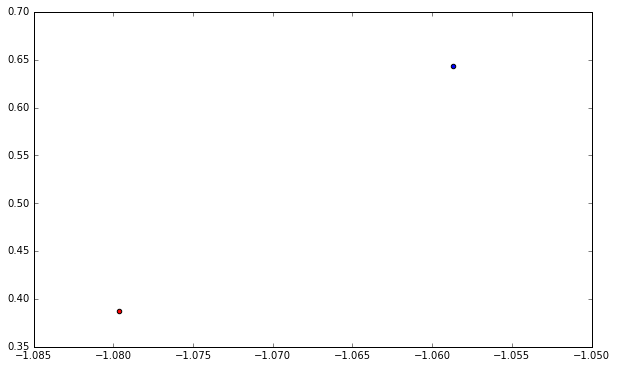

In [43]:
# Center the path
ctr_path = path - centroid

a = ctr_path[i]
b = ctr_path[i+1]

plt.scatter(a[0],a[1], c='blue')
plt.scatter(b[0],b[1], c='red')

def is_ccw(a, b):
    # 1 if b is on CCW side of a,
    # -1 if b is on CW side of a,
    # 0 if b is parallel to a.
    return np.sign(rot(a,b))

def rot(a, b):
    # Represents magnitude and direction of rotation.
    # + if b is on CW side of a,
    # - if b is on CCW side of a,
    # 0 if b is parallel to a.
    return a[1]*b[0] - a[0]*b[1]

bias = lambda s: np.sum((np.array(s)+1)/2)/len(s) # CCW / (CCW + CW)
integral_bias = lambda s: np.cumsum((np.array(s)+1)/2)/np.linspace(1,len(s),len(s)) # integral (CCW / (CCW + CW))

# Dealing with long chains of NaNs

def fixnan(x):
    # Fill in NaNs by linear interpolation.
    mask = np.isnan(x)
    x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), x[~mask])
    return x

# TODO: make cleaner
def get_nan_streaks(x):
    # Brute force...
    # Records the length of different streaks of nans.
    # If a streak is too long, then we'll have to deal with it later.
    nan_streaks = []
    streak_start = False
    streak_end = False
    x0_is_nan = False
    
    # Checks if all nan
    if len(x) == np.isnan(x).sum():
        nan_streaks = [(0, len(x)-1)]
        return np.array(nan_streaks)
    
    if np.isnan(x[0]): x0_is_nan = True
    
    for i in range(len(x)):
        if np.isnan(x[i]) and i != len(x) - 1:
            if not streak_start:
                streak_start = streak_end = i
            else:
                streak_end = i
        else:
            if (streak_start ) and streak_end:
                if np.isnan(x[i]) and i == len(x) - 1:
                    nan_streaks += [(streak_start, i)]
                else:
                    nan_streaks += [(streak_start, streak_end)]
            elif streak_start or x0_is_nan:
                nan_streaks += [(streak_start, streak_start)]
                x0_is_nan = False
            streak_start = streak_end = False
    
    return np.array(nan_streaks)

def valid_data_stretch(data, min_data_streak=3, max_nan_streak=11):
    # returns interval of data where there are no
    # chains of nans exceeding the maximum streak.
    inds = []

    streaks = get_nan_streaks(data)
    
    if streaks == None or len(streaks) == 0:
        return (0, len(data)-1)
    
    streak_len = lambda ns: ns[1] - ns[0] + 1
    streak_lengths = np.apply_along_axis(streak_len, 1, streaks)
    
    # find the longest stretch of data, ignoring nan streaks 
    # shorter than max allowed.
    # stretch of data must be at least the minimum.
    
    data_start, data_end = 0, 0
    
    for s in streaks:
        if streak_len(s) <= max_nan_streak:
            data_end = s[1]
        else:
            data_start = data_end = s[1] + 1
    
    # include remaining data if it can never exceed max_nan_streak
    if len(data) - s[1] < max_nan_streak:
        data_end = len(data) - 1
            
    if np.max(streak_lengths) > max_nan_streak:
        return None, None
    
    if data_end - data_start + 1 <= min_data_streak:
        return None, None
    
    return data_start, data_end


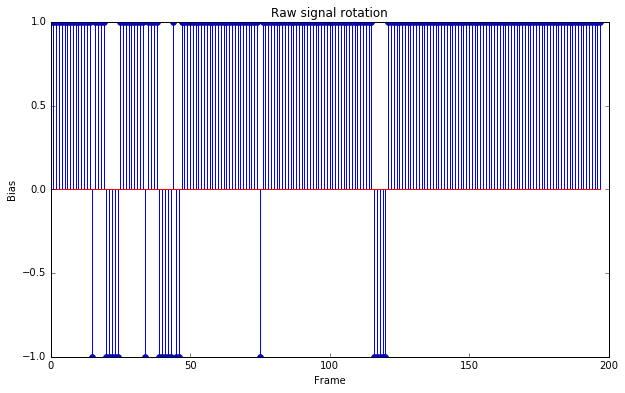

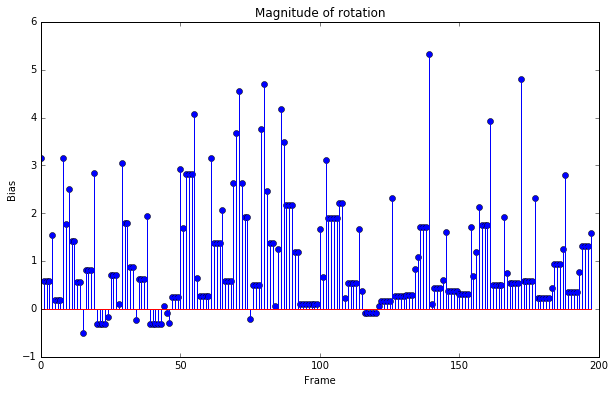

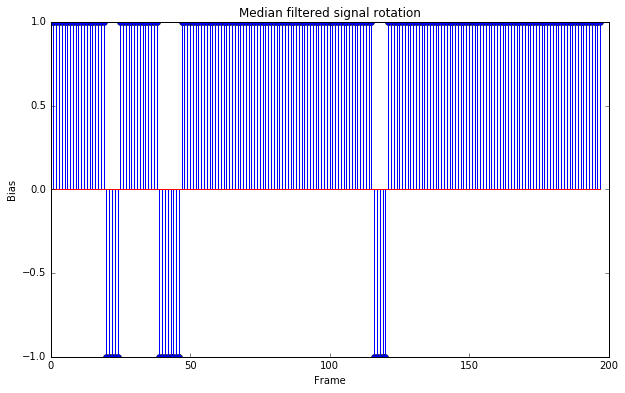

(198,)


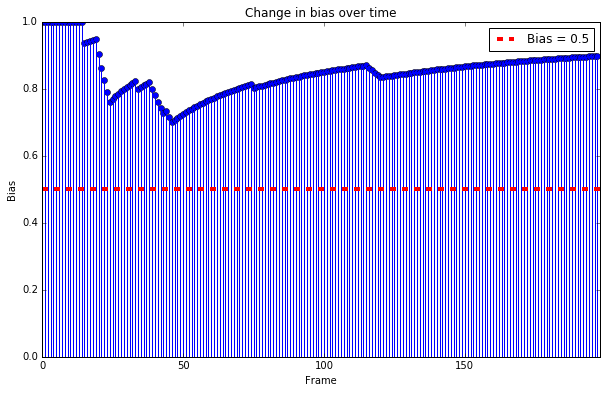

In [44]:
show_frames = len(ctr_path)-1
particle_rotation_direction = []
for i in range(0,show_frames):#len(ctr_path)-1):
    a = ctr_path[i]
    b = ctr_path[i+1]
    particle_rotation_direction += [is_ccw(a,b)]

rotation_mag = []
for i in range(0,show_frames):#len(ctr_path)-1):
    a = ctr_path[i]
    b = ctr_path[i+1]
    rotation_mag += [rot(a,b)]
    
plt.figure()
plt.title('Raw signal rotation')
plt.xlabel('Frame'); plt.ylabel('Rotation Direction')
particle_rotation_direction = fixnan(np.array(particle_rotation_direction))
plt.stem(particle_rotation_direction)
plt.show()

plt.figure()
plt.title('Magnitude of rotation')
plt.xlabel('Frame'); plt.ylabel('Rotation Direction')
plt.stem(rotation_mag)
plt.show()

for ker_size in [3]:
    plt.figure()
    plt.title('Median filtered signal rotation')
    plt.xlabel('Frame'); plt.ylabel('Rotation direction')
    filtered_rotation_directions = np.sign(scipy.signal.medfilt(rotation_mag, kernel_size=ker_size))
    filtered_rotation_directions = fixnan(filtered_rotation_directions)
    plt.stem(filtered_rotation_directions)
    plt.show()

    plt.figure()
    plt.title('Change in bias over time')
    plt.xlabel('Frame'); plt.ylabel('Bias')
    bias_at_time = integral_bias(particle_rotation_direction)
    print(bias_at_time.shape)
    plt.stem(bias_at_time)
    plt.plot(np.linspace(0,len(bias_at_time),len(bias_at_time)), 0.5*np.ones(len(bias_at_time)),
             ls='--', c='red', lw=4, label='Bias = 0.5')
    plt.legend(loc='upper right')
    plt.axis('tight')
    plt.show()

In [45]:
# Compute bias for a single path
print('Bias:', bias(particle_rotation_direction))

Bias: 0.89898989899


In [25]:
# Now, repeat above to find bias for all particles.

In [49]:
use_med_filter = False
filter_kernel = 3
max_nan_streak = 100
min_data_streak = 50

biases = []
# valid_paths=[]
for i in range(len(particle_paths)):
    p = particle_paths.iloc[i]
    path = np.array([p['x'],p['y']]).T

    valid_start, valid_end = valid_data_stretch(path[:,0],
                                min_data_streak=min_data_streak,
                                max_nan_streak=max_nan_streak)
    if valid_start == None:
        continue

    # Linear interpolation of remaining NaNs
    path = path[valid_start:valid_end]
    fixnan(path[:,0])
    fixnan(path[:,1])

    centroid = np.nanmean(path, axis=0)
    
    # Center the path about (0,0)
    ctr_path = path - centroid

#     valid_paths+=[ctr_path]
        
    rotation_directions = []
    for j in range(len(ctr_path)-1):
        a = ctr_path[j]
        b = ctr_path[j+1]
        if use_med_filter:
            rotation_directions += [rot(a,b)]
        else:
            rotation_directions += [is_ccw(a,b)]

    rotation_directions = fixnan(np.array(rotation_directions))
    
    if use_med_filter:
        filtered_rotation_directions = np.sign(scipy.signal.medfilt(rotation_directions, 
                                                                    kernel_size=filter_kernel))
        
        filtered_rotation_directions = fixnan(np.array(filtered_rotation_directions))
        biases += [bias(filtered_rotation_directions)]
    else:
        biases += [bias(rotation_directions)]
    
print(len(biases))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


139


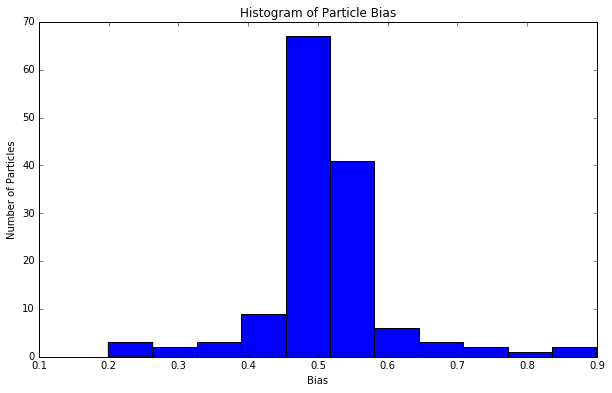

In [50]:
plt.figure()
plt.title('Histogram of Particle Bias')
plt.xlabel('Bias')
plt.ylabel('Number of Particles')
plt.hist(biases, bins=11);
plt.show()

In [ ]:
print np.zeros(2,3)